In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

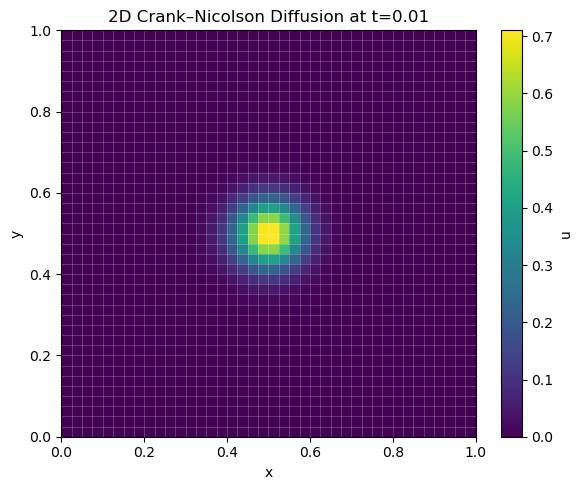

In [ ]:
def crank_nicolson_2d(x_edges, y_edges, D, u0, dt, T, verbose=False):
    # x_edges, y_edges : edge arrays length Nx+1, Ny+1
    # D, u0 : cell-centered arrays shape (Nx, Ny)
    Nx = len(x_edges) - 1
    Ny = len(y_edges) - 1
    dx = x_edges[1:] - x_edges[:-1]  # length Nx
    dy = y_edges[1:] - y_edges[:-1]  # length Ny

    N = Nx * Ny
    u = u0.reshape(N)

    def idx(i, j):
        return i * Ny + j

    rows = []
    cols = []
    vals = []

    for i in range(Nx):
        for j in range(Ny):
            p = idx(i, j)
            diag = 0.0

            # West face
            if i > 0:
                D_w = 0.5 * (D[i, j] + D[i - 1, j])
                dx_w = 0.5 * (dx[i - 1] + dx[i])
                coef = D_w / (dx_w * dx[i])
                rows.append(p)
                cols.append(idx(i - 1, j))
                vals.append(+coef)
                diag -= coef

            # East face
            if i < Nx - 1:
                D_e = 0.5 * (D[i, j] + D[i + 1, j])
                dx_e = 0.5 * (dx[i] + dx[i + 1])
                coef = D_e / (dx_e * dx[i])
                rows.append(p)
                cols.append(idx(i + 1, j))
                vals.append(+coef)
                diag -= coef

            # South face
            if j > 0:
                D_s = 0.5 * (D[i, j] + D[i, j - 1])
                dy_s = 0.5 * (dy[j - 1] + dy[j])
                coef = D_s / (dy_s * dy[j])
                rows.append(p)
                cols.append(idx(i, j - 1))
                vals.append(+coef)
                diag -= coef

            # North face
            if j < Ny - 1:
                D_n = 0.5 * (D[i, j] + D[i, j + 1])
                dy_n = 0.5 * (dy[j] + dy[j + 1])
                coef = D_n / (dy_n * dy[j])
                rows.append(p)
                cols.append(idx(i, j + 1))
                vals.append(+coef)
                diag -= coef

            rows.append(p)
            cols.append(p)
            vals.append(diag)

    A = sp.csr_matrix((vals, (rows, cols)), shape=(N, N))

    # Diagnostics
    if verbose:
        sym_diff = (A - A.T).nnz
        row_sums = np.array(A.sum(axis=1)).ravel()
        print("A - A.T nonzeros:", sym_diff)
        print("row_sums min/max:", row_sums.min(), row_sums.max())
        print("diag min/max:", A.diagonal().min(), A.diagonal().max())

    M_L = sp.eye(N) - 0.5 * dt * A
    M_R = sp.eye(N) + 0.5 * dt * A

    steps = int(round(T / dt))
    for _ in range(steps):
        rhs = M_R @ u
        u = spla.spsolve(M_L, rhs)

    return u.reshape((Nx, Ny)), A


# ------------------------------------------------------------
# 2) UNIFORM 2D MESH GENERATOR
# ------------------------------------------------------------
def make_uniform_mesh_2d(Nx, Ny):
    x = np.linspace(0, 1, Nx + 1)
    y = np.linspace(0, 1, Ny + 1)
    xc = 0.5 * (x[:-1] + x[1:])
    yc = 0.5 * (y[:-1] + y[1:])
    return x, y, xc, yc


# ------------------------------------------------------------
# 3) AMBIPOLAR DIFFUSION COEFFICIENT
# ------------------------------------------------------------
def ambipolar_D_2d(xc, yc, mu_i=10.0, mu_e=100.0):
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")

    # simple spatial variation for testing
    Di = 0.02 + 0.01 * np.sin(2 * np.pi * Xc)
    De = 0.50 + 0.20 * np.cos(2 * np.pi * Yc)

    return (mu_i * De + mu_e * Di) / (mu_i + mu_e)


# ------------------------------------------------------------
# 4) RUN A SIMPLE 2D TEST
# ------------------------------------------------------------
Nx = 40
Ny = 40
dt = 1e-4
T = 0.01

# Mesh
x, y, xc, yc = make_uniform_mesh_2d(Nx, Ny)

# Diffusion coefficient
D = ambipolar_D_2d(xc, yc)


# Initial condition (Gaussian)
def initial_condition(xc, yc):
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")
    # Using a slightly sharper Gaussian to test the refinement
    return np.exp(-((Xc - 0.5) ** 2 + (Yc - 0.5) ** 2) / 0.005)


u0 = initial_condition(xc, yc)

# Solve with CN
u, A = crank_nicolson_2d(x, y, D, u0, dt, T)

# ------------------------------------------------------------
# 5) PLOT THE RESULT
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.pcolormesh(x, y, u.T, shading="auto")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"2D Crank–Nicolson Diffusion at t={T}")

plt.vlines(x, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.hlines(y, 0, 1, color="w", alpha=0.3, lw=0.5)

plt.colorbar(label="u")
plt.tight_layout()
plt.show()

In [58]:
def refine_uniform_mesh_2d(x, y):
    Nx = len(x) - 1
    Ny = len(y) - 1

    # Build refined edges by inserting midpoint directly
    x_new = np.empty(2 * Nx + 1)
    y_new = np.empty(2 * Ny + 1)

    # Fill edges
    x_new[0::2] = x  # 0, 2, 4, ...
    x_new[1::2] = 0.5 * (x[:-1] + x[1:])  # midpoints

    y_new[0::2] = y
    y_new[1::2] = 0.5 * (y[:-1] + y[1:])

    # Compute centers
    xc_new = 0.5 * (x_new[:-1] + x_new[1:])
    yc_new = 0.5 * (y_new[:-1] + y_new[1:])

    return x_new, y_new, xc_new, yc_new

In [ ]:
def refine_adaptive_mesh(x_edges, y_edges, u_field, threshold_ratio=0.5):
    """
    Refines mesh where gradient magnitude of u_field is high.
    Maintains rectangular tensor-product structure.
    """
    xc = 0.5 * (x_edges[:-1] + x_edges[1:])
    yc = 0.5 * (y_edges[:-1] + y_edges[1:])

    # 1. Compute Gradients
    # np.gradient handles non-uniform spacing if we pass xc, yc
    grads = np.gradient(u_field, xc, yc)
    grad_mag = np.sqrt(grads[0] ** 2 + grads[1] ** 2)

    # 2. Determine Threshold
    # We refine any cell where gradient is > X% of the max gradient
    threshold = threshold_ratio * np.max(grad_mag)
    mask = grad_mag > threshold

    # 3. Project Mask to Axes
    # Since the solver loops (for i in Nx), we must refine the WHOLE column i
    # if ANY cell in that column has a sharp gradient.
    # axis 1 is y-axis (columns), axis 0 is x-axis (rows)
    refine_x_indices = np.any(mask, axis=1)
    refine_y_indices = np.any(mask, axis=0)

    # 4. Helper to insert midpoints
    def split_edges(edges, should_split):
        new_edges = []
        for i, split in enumerate(should_split):
            new_edges.append(edges[i])
            if split:
                new_edges.append(0.5 * (edges[i] + edges[i + 1]))
        new_edges.append(edges[-1])
        return np.array(new_edges)

    x_new = split_edges(x_edges, refine_x_indices)
    y_new = split_edges(y_edges, refine_y_indices)

    xc_new = 0.5 * (x_new[:-1] + x_new[1:])
    yc_new = 0.5 * (y_new[:-1] + y_new[1:])

    return x_new, y_new, xc_new, yc_new

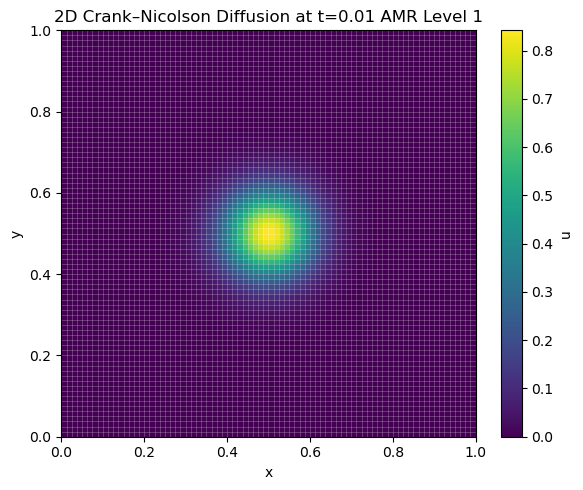

In [ ]:
x, y, xc, yc = make_uniform_mesh_2d(40, 40)
x2, y2, xc2, yc2 = refine_uniform_mesh_2d(x, y)

D = ambipolar_D_2d(xc2, yc2)

Xc2, Yc2 = np.meshgrid(xc2, yc2, indexing="ij")
u0 = np.exp(-((Xc2 - 0.5) ** 2 + (Yc2 - 0.5) ** 2) / 0.01)

u_amr1, A = crank_nicolson_2d(x2, y2, D, u0, dt, T)
plt.figure(figsize=(6, 5))
plt.pcolormesh(xc2, yc2, u_amr1.T, shading="auto")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"2D Crank–Nicolson Diffusion at t={T} AMR Level 1")
plt.vlines(x2, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.hlines(y2, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.colorbar(label="u")
plt.tight_layout()
plt.show()

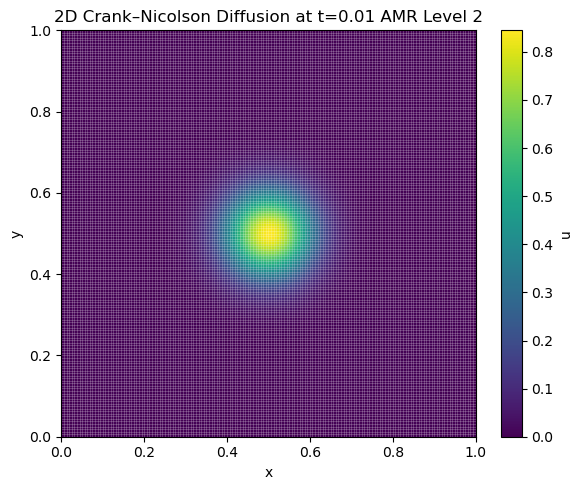

In [ ]:
x3, y3, xc3, yc3 = refine_uniform_mesh_2d(x2, y2)
D = ambipolar_D_2d(xc3, yc3)

Xc3, Yc3 = np.meshgrid(xc3, yc3, indexing="ij")
u0 = np.exp(-((Xc3 - 0.5) ** 2 + (Yc3 - 0.5) ** 2) / 0.01)

u_amr2, A = crank_nicolson_2d(x3, y3, D, u0, dt, T)
plt.figure(figsize=(6, 5))
plt.pcolormesh(x3, y3, u_amr2.T, shading="auto")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"2D Crank–Nicolson Diffusion at t={T} AMR Level 2")
plt.vlines(x3, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.hlines(y3, 0, 1, color="w", alpha=0.3, lw=0.5)
plt.colorbar(label="u")
plt.tight_layout()
plt.show()

1. Running Coarse (40x40)...
2. Running Adaptive (50x50)...


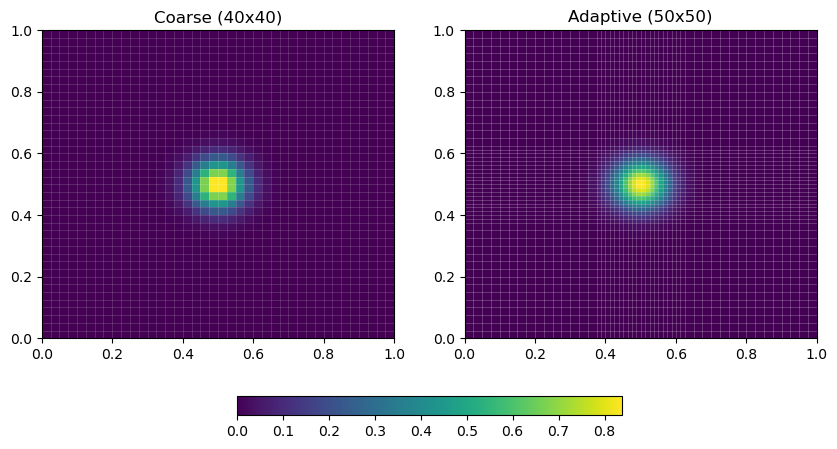

In [ ]:
# ------------------------------------------------------------
# 4) EXECUTION
# ------------------------------------------------------------
dt = 1e-4
T = 0.005  # Short time to keep gradients sharp

# --- A) Coarse Pass ---
Nx, Ny = 40, 40
x, y, xc, yc = make_uniform_mesh_2d(Nx, Ny)
D = ambipolar_D_2d(xc, yc)
u0 = initial_condition(xc, yc)

print(f"1. Running Coarse ({len(xc)}x{len(yc)})...")
u_coarse, _ = crank_nicolson_2d(x, y, D, u0, dt, T)

# --- B) Adaptive Refinement ---
# Use the result from the coarse pass to determine where to refine
x2, y2, xc2, yc2 = refine_adaptive_mesh(x, y, u_coarse, threshold_ratio=0.2)

# --- C) Fine Pass ---
# Re-initialize on new mesh
# (In a real transient sim, you would interpolate u_coarse -> u0_2)
D2 = ambipolar_D_2d(xc2, yc2)
u0_2 = initial_condition(xc2, yc2)

print(f"2. Running Adaptive ({len(xc2)}x{len(yc2)})...")
u_fine, _ = crank_nicolson_2d(x2, y2, D2, u0_2, dt, T)


# ------------------------------------------------------------
# 5) VISUALIZATION
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot Coarse
X, Y = np.meshgrid(x, y, indexing="ij")
ax[0].pcolormesh(X, Y, u_coarse, shading="flat", cmap="viridis")
# Draw grid lines
ax[0].vlines(x, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].hlines(y, 0, 1, color="w", alpha=0.2, lw=0.5)
ax[0].set_title(f"Coarse ({Nx}x{Ny})")

# Plot Adaptive
X2, Y2 = np.meshgrid(x2, y2, indexing="ij")
pcm = ax[1].pcolormesh(X2, Y2, u_fine, shading="flat", cmap="viridis")
# Draw grid lines - NOTICE THE DENSITY IN THE CENTER
ax[1].vlines(x2, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[1].hlines(y2, 0, 1, color="w", alpha=0.3, lw=0.5)
ax[1].set_title(f"Adaptive ({len(xc2)}x{len(yc2)})")

plt.colorbar(pcm, ax=ax, orientation="horizontal", fraction=0.05)
plt.show()